# **AI60003: ARTIFICIAL INTELLIGENCE FOR ECONOMICS**

## Assignment 1: Stock Price Movement Prediction using Sentiment Analysis

## Abhinav Bohra, 18CS30049
<hr>








Note: In this notebook, I have compared perfomance of the following 2 models on stock price prediction task:-

1.   LSTM model without sentiment signal
2.   LSTM model with sentiment signal

I have created functions for common tasks to make the code more modular and re-usable


In [ ]:
#Importing important libraries
import math 
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

## **Loading the Dataset**
**Perparing Stock Price Data**

Scraping Historical Stock Price Data of Apple Inc. from Yahoo Finance

In [ ]:
#Downloading hostorical stock price data from 1st Jan 2017 to today
stockname = 'AAPL'
interval = '1d' 
date_today = date.today()
date_start = datetime.strptime('2017-01-01', "%Y-%m-%d")

period1 = int(time.mktime(date_start.timetuple()))
period2 = int(time.mktime(date_today.timetuple()))
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{stockname}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

#Saving data to CSV file
stocks_data = pd.read_csv(query_string)
stocks_data.to_csv(stockname + '.csv')

#Loading data into dataframe
df = pd.read_csv(stockname + '.csv',parse_dates = True,index_col=['Date'])
df = df.drop(['Unnamed: 0'],axis=1)

## **Exploratory Data Analysis**

In [ ]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332474,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301880,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440720,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746634,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000778,134247600


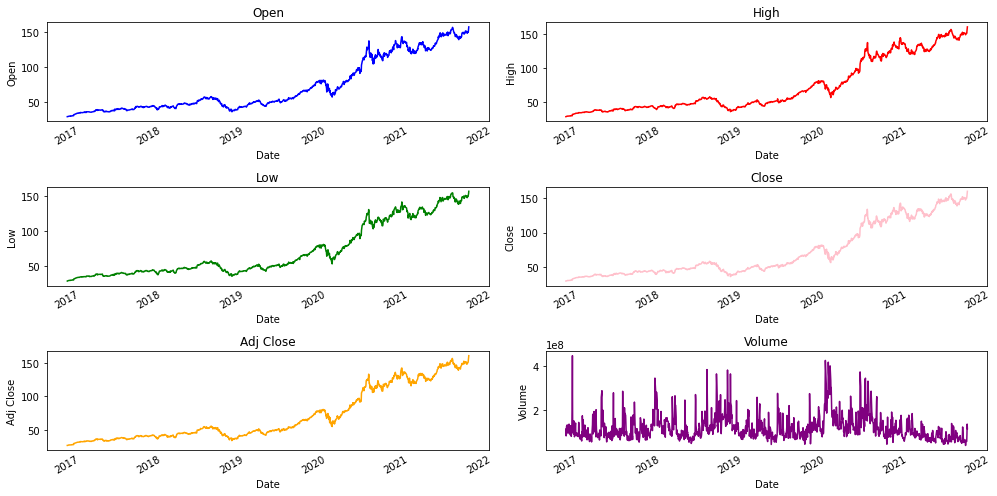

In [ ]:
# Plotting line charts
df_plot = df.copy()
list_length = df_plot.shape[1]
ncols = 2
nrows = int(round(list_length / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
colors = ['blue', 'red', 'green', 'pink', 'orange', 'purple']
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax, color= colors[i])
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.tight_layout()
plt.show()

## **Data-Preprocessing**

In [ ]:
# Creating n samples, sequence_length time steps per samples
def splitData(sequence_length, data, index_Close):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        #contains sequence_length values 0-sequence_length * columns
        x.append(data[i-sequence_length:i,:]) 
        #contains the prediction values for validation,  for single-step prediction
        y.append(data[i, index_Close]) 
    # Convert the x & y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

def processData(df, FEATURES):
  # Indexing  the batches
  train_df = df.sort_values(by=['Date']).copy()
  # Saving a copy of the dates index, before we need to reset it to numbers
  date_index = train_df.index
  # Reset the index, so we can convert the date-index to a number-index
  train_df = train_df.reset_index(drop=True).copy()
  # Create the dataset with features and filter the data to the list of FEATURES
  data = pd.DataFrame(train_df)
  data_filtered = data[FEATURES]

  # Adding a prediction column (target varaible) and setting dummy values to prepare the data for scaling
  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']
  # Number of rows in the data
  nrows = data_filtered.shape[0]
  # Convert data to numpy values
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)
  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # sequence length: this is the timeframe used to make a single prediction
  sequence_length = 50
  # Prediction Index
  index_Close = data.columns.get_loc("Close")
  # Split the training data into train and test datasets with 80:20 split 
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
  # Creating the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]

  # Generate training data and test data
  x_train, y_train = splitData(sequence_length, train_data, index_Close)
  x_test, y_test = splitData(sequence_length, test_data, index_Close)

  return x_train, y_train, x_test, y_test, data_filtered, \
         date_index, scaler, scaler_pred, train_data_len, sequence_length

## **Model Training**

In [ ]:
#Setting up LSTM model architecture

def getModel(x_train):
  # Creating model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  model = Sequential()
  n_neurons = x_train.shape[1] * x_train.shape[2]
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compiling the model
  model.compile(optimizer='adam', loss='mse')
  return model

In [ ]:
def plotLossCurve(history, color, title):
  # Plot the Loss Curve
  fig, ax = plt.subplots(figsize=(7, 6), sharex=True)
  plt.plot(history.history["loss"],color=color)
  plt.title(title)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.xticks(rotation=45)
  plt.legend(["Train", "Test"], loc="upper left")
  plt.show()

## **Evaluating model performance**

In [ ]:
def eval(model, x_test, y_test, scaler_pred):
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)
  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  return MAE, MAPE, MDAPE, y_pred

## **Visualizing Predictions**

In [ ]:
def visualizePreds(data_filtered, train_data_len, y_pred, date_index, color):
  # The date from which on the date is displayed
  display_start_date = pd.Timestamp('today') - timedelta(days=500)
  # Add the date column
  data_filtered_sub = data_filtered.copy()
  data_filtered_sub['Date'] = date_index

  # Add the difference between the valid and predicted prices
  train = data_filtered_sub[:train_data_len + 1]
  valid = data_filtered_sub[train_data_len:]
  
  valid.insert(1, "Prediction", y_pred.ravel(), True)
  valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
  # Zoom in to a closer timeframe
  valid = valid[valid['Date'] > display_start_date]
  train = train[train['Date'] > display_start_date]
  
  # Visualize the data
  fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
  xt = train['Date']; yt = train[["Close"]]
  xv = valid['Date']; yv = valid[["Close", "Prediction"]]
  plt.title("Predictions vs Actual Values", fontsize=20)
  plt.ylabel(stockname, fontsize=18)
  plt.plot(xt, yt, color="green", linewidth=2.0)
  plt.plot(xv, yv["Prediction"], color=color, linewidth=2.0)
  plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
  plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")
  plt.show()

## **Predicting Next Day's Price**

In [ ]:
def predictFuturePrice(model, df, sequence_length, feats, scaler, scaler_pred):
  df_temp = df[-sequence_length:]
  new_df = df_temp.filter(feats)
  N = sequence_length
  # Get the last N day closing price values and scale the data to be values between 0 and 1
  last_N_days = new_df[-sequence_length:].values
  last_N_days_scaled = scaler.transform(last_N_days)

  # Create an empty list and Append past N days
  X_test_new = []
  X_test_new.append(last_N_days_scaled)
  # Convert the X_test data set to a numpy array and reshape the data
  pred_price_scaled = model.predict(np.array(X_test_new))
  pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
  # Print last price and predicted price for the next day
  price_today = np.round(new_df['Close'][-1], 2)
  predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

  plus = '+'; minus = ''
  print(f'The close price for {stockname} at {date_today} was {price_today}')
  print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

<br><br><br><br>
# **Assembling model 1: LSTM without sentiment signal**
<hr>

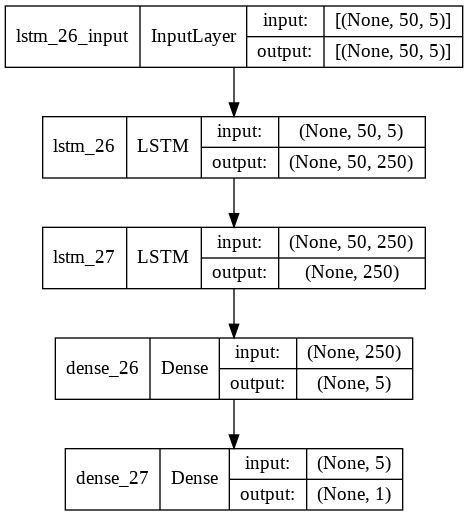

In [ ]:
# List of considered features
features1 = ['High', 'Low', 'Open', 'Close', 'Volume']  
# Split and process dataset
x_train1, y_train1, x_test1, y_test1, data_filtered1, date_index1, \
scaler1, scaler_pred1, train_data_len1, sequence_length1 = processData(df, features1)
# Get Model
model1 = getModel(x_train1)
#Visualizing Model Architecture
import tensorflow as tf
tf.keras.utils.plot_model(model1, show_shapes=True)

In [ ]:
model1.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 50, 250)           256000    
                                                                 
 lstm_27 (LSTM)              (None, 250)               501000    
                                                                 
 dense_26 (Dense)            (None, 5)                 1255      
                                                                 
 dense_27 (Dense)            (None, 1)                 6         
                                                                 
Total params: 758,261
Trainable params: 758,261
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model
epochs = 50
history1 = model1.fit(x_train1, y_train1, batch_size=512, epochs=epochs, validation_data=(x_test1, y_test1),\
                     callbacks=[EarlyStopping(monitor='loss', patience=5, verbose=1)])

Epoch 1/50
2/2 [==============================] - 11s 4s/step - loss: 0.0512 - val_loss: 0.0034
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 0.0045 - val_loss: 0.0842
Epoch 3/50
2/2 [==============================] - 6s 3s/step - loss: 0.0090 - val_loss: 0.0228
Epoch 4/50
2/2 [==============================] - 6s 3s/step - loss: 0.0020 - val_loss: 0.0122
Epoch 5/50
2/2 [==============================] - 6s 3s/step - loss: 0.0030 - val_loss: 0.0199
Epoch 6/50
2/2 [==============================] - 6s 3s/step - loss: 0.0021 - val_loss: 9.4518e-04
Epoch 7/50
2/2 [==============================] - 6s 3s/step - loss: 7.6208e-04 - val_loss: 0.0109
Epoch 8/50
2/2 [==============================] - 6s 3s/step - loss: 0.0021 - val_loss: 0.0111
Epoch 9/50
2/2 [==============================] - 6s 3s/step - loss: 0.0015 - val_loss: 0.0024
Epoch 10/50
2/2 [==============================] - 6s 3s/step - loss: 5.0130e-04 - val_loss: 0.0021
Epoch 11/50
2/2 [===================

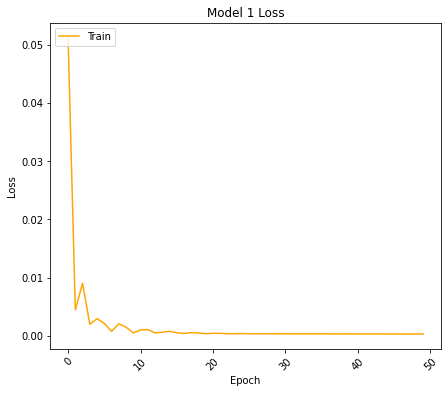

In [ ]:
# Plotting Loss Curve
plotLossCurve(history1,"orange", "Model 1 Loss")     

In [ ]:
# Evaluating model
MAE1, MAPE1, MDAPE1, y_pred1= eval(model1, x_test1, y_test1, scaler_pred1)

Median Absolute Error (MAE): 3.11
Mean Absolute Percentage Error (MAPE): 2.27 %
Median Absolute Percentage Error (MDAPE): 1.87 %


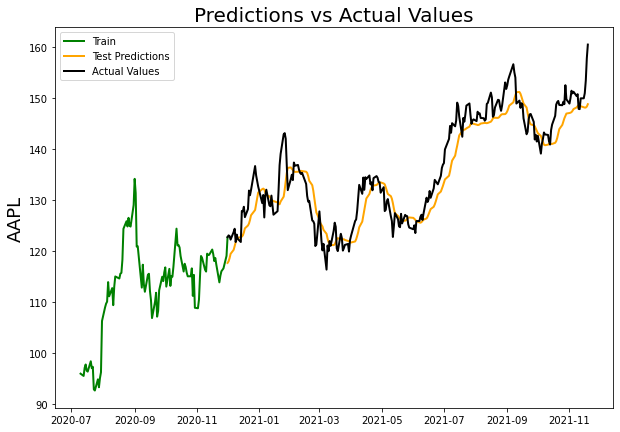

In [ ]:
# Visualising Predictions
visualizePreds(data_filtered1, train_data_len1, y_pred1, date_index1, "orange")

In [ ]:
#Predicting Next Day's Price
predictFuturePrice(model1, df, sequence_length1, features1, scaler1, scaler_pred1)

The close price for AAPL at 2021-11-21 was 160.55
The predicted close price is 149.72000122070312 (-7.23%)


# **Sentiment Analysis using BERT**
<hr>

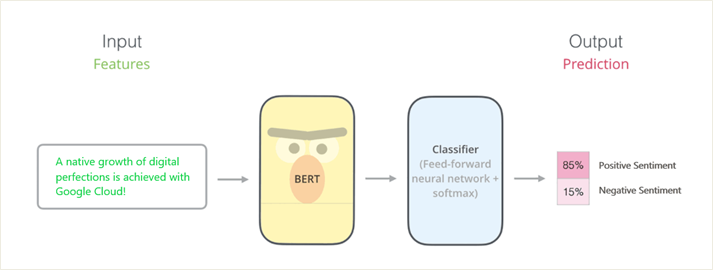

**Perparing Tweet Data for Sentiment Analysis**

Scraping Tweets from Official Apple Account on Twitter

In [ ]:
!pip install -q snscrape
!pip install -q tqdm
!pip install -q transformers

In [ ]:
import csv
import json
import datetime
import pandas as pd
from tqdm import tqdm
import snscrape.modules.twitter as sntwitter

if os.path.isfile(stockname + '_tweets.json', 'w'):
  print("File already exits...no need to scrape it again")
  print("To scrape again, delete : " + stockname + '_tweets.json')
else:
  maxTweets = 3
  start_date = date_start.date()
  period = (date_today - start_date).days

  tweets = dict()
  for i in tqdm(range(period)):
    dayTweets=list()
    start_interval = start_date
    end_interval = start_interval + datetime.timedelta(days=1)
    try: 
      for i,tweet in enumerate(sntwitter.TwitterSearchScraper('#Apple + OR @Apple + since:' + str(start_interval) + ' until:' + str(end_interval) +' -filter:links -filter:replies  lang:"en" ').get_items()):
          if i > maxTweets :
            break  
          dayTweets.append(tweet.content)
      key = start_date.strftime('%d/%m/%Y')
      tweets[key] = dayTweets
      start_date += datetime.timedelta(days=1)  
    except Exception as e:
      print(i,e)
      pass

  with open( stockname + '_tweets.json', 'w') as fp:
      json.dump(tweets, fp)

### **Calculating Sentiment Score for every tweet**

In [ ]:
import os, csv
import urllib.request
from scipy.special import softmax
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

In [ ]:
! rm -rf cardiffnlp #Remove tokenizer cache
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

#Create BERT Tokenizer
task = "sentiment"
BERT_MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)

# Downloading label mapping
labels = list()
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL)
bert_model.save_pretrained(BERT_MODEL)

Loading Tweets and creating a new dataframe

In [ ]:
import json
f = open(stockname + '_tweets.json',)
data = json.load(f)

dates = list()
NEG = list()
NEU = list()
POS = list()

for key in tqdm(data):
  reviews = data[key]
  pos=0
  neg=0
  neu=0
  cnt=0
  for text in reviews:
    cnt=cnt+1
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    neg=neg+scores[0]
    neu=neu+scores[1]
    pos=pos+scores[2]

  NEG.append(neg/cnt)
  NEU.append(neu/cnt)
  POS.append(pos/cnt)
  dates.append(datetime.strptime(str(key), "%d/%m/%Y"))

100%|██████████| 1785/1785 [22:23<00:00,  1.33it/s]


In [ ]:
df_senti = pd.DataFrame({"Date": dates, 'NEG':NEG, 'NEU':NEU, 'POS':POS})
df_senti['Date'] = pd.to_datetime(df_senti['Date'])
df_senti.to_csv(stockname + '_senti_scores.csv')

**Aligning both the dataframes**

Preparing dataset: (Date,Stock Price,Sentiment_Score)

In [ ]:
df_senti = pd.read_csv(stockname + '_senti_scores.csv')
df_senti.set_index('Date', inplace=True)
df2 = df.join(df_senti, how='inner')
df2.head()

,Open,High,Low,Close,Adj Close,Volume,NEG,NEU,POS
Date,,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332474,115127600,0.784301,0.193601,0.355431
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301880,84472400,0.710159,0.436134,0.187041
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440720,88774400,0.180127,0.485245,0.667961
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746634,127007600,0.496788,0.568298,0.268247
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000778,134247600,0.356566,0.494585,0.482182


<br><br><br><br>
# **Assembling model 2: LSTM with sentiment signal**
<hr>

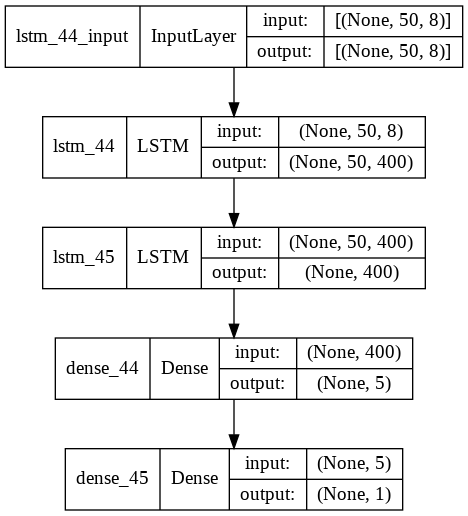

In [ ]:
# List of considered features
features2 = ['High', 'Low', 'Open', 'Close', 'Volume', 'NEG', 'NEU', 'POS']
# Split and process dataset
x_train2, y_train2, x_test2, y_test2, data_filtered2, date_index2, \
scaler2, scaler_pred2, train_data_len2, sequence_length2 = processData(df2, features2)
# Get Model
model2 = getModel(x_train2)
#Visualizing Model Architecture
import tensorflow as tf
tf.keras.utils.plot_model(model2, show_shapes=True)

In [ ]:
model2.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 50, 400)           654400    
                                                                 
 lstm_45 (LSTM)              (None, 400)               1281600   
                                                                 
 dense_44 (Dense)            (None, 5)                 2005      
                                                                 
 dense_45 (Dense)            (None, 1)                 6         
                                                                 
Total params: 1,938,011
Trainable params: 1,938,011
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Training the model
epochs = 50
history2 = model2.fit(x_train2, y_train2, batch_size=512, epochs=epochs, validation_data=(x_test2, y_test2),\
                     callbacks=[EarlyStopping(monitor='loss', patience=5, verbose=1)])

Epoch 1/50
2/2 [==============================] - 18s 7s/step - loss: 0.2390 - val_loss: 0.0256
Epoch 2/50
2/2 [==============================] - 13s 7s/step - loss: 0.0180 - val_loss: 0.2972
Epoch 3/50
2/2 [==============================] - 13s 7s/step - loss: 0.0439 - val_loss: 0.1200
Epoch 4/50
2/2 [==============================] - 13s 7s/step - loss: 0.0093 - val_loss: 0.0042
Epoch 5/50
2/2 [==============================] - 13s 7s/step - loss: 0.0138 - val_loss: 0.0137
Epoch 6/50
2/2 [==============================] - 13s 7s/step - loss: 0.0059 - val_loss: 0.0100
Epoch 7/50
2/2 [==============================] - 13s 6s/step - loss: 0.0029 - val_loss: 0.0306
Epoch 8/50
2/2 [==============================] - 13s 6s/step - loss: 0.0075 - val_loss: 0.0166
Epoch 9/50
2/2 [==============================] - 13s 7s/step - loss: 0.0044 - val_loss: 0.0011
Epoch 10/50
2/2 [==============================] - 13s 7s/step - loss: 9.0231e-04 - val_loss: 0.0149
Epoch 11/50
2/2 [==================

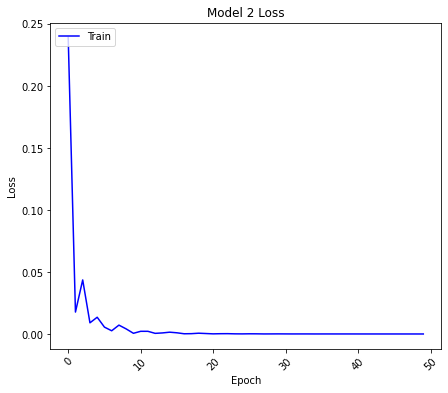

In [ ]:
# Plotting Loss Curve
plotLossCurve(history2,"blue", "Model 2 Loss")     

In [ ]:
# Evaluating model
MAE2, MAPE2, MDAPE2, y_pred2 = eval(model2, x_test2, y_test2, scaler_pred2)

Median Absolute Error (MAE): 3.08
Mean Absolute Percentage Error (MAPE): 2.28 %
Median Absolute Percentage Error (MDAPE): 1.92 %


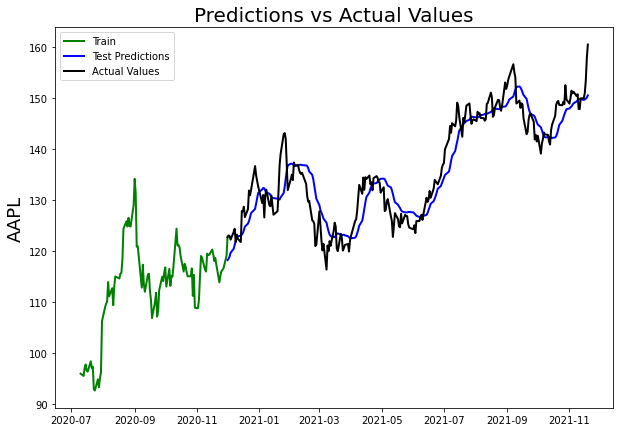

In [ ]:
#Visualisng Predictions
visualizePreds(data_filtered2, train_data_len2, y_pred2, date_index2, "blue")

In [ ]:
#Predicting Next Day's Price
predictFuturePrice(model2, df2, sequence_length2, features2, scaler2, scaler_pred2)

The close price for AAPL at 2021-11-21 was 160.55
The predicted close price is 151.24000549316406 (-6.16%)


<br><br><br><br>
# **Results Comparision**
<hr>

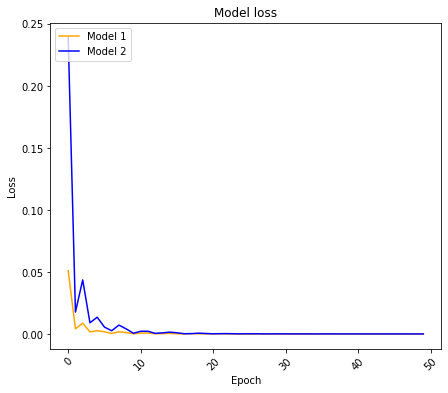

In [ ]:
# Plot the Loss Curve
fig, ax = plt.subplots(figsize=(7, 6), sharex=True)
plt.plot(history1.history["loss"],color="orange")
plt.plot(history2.history["loss"],color="blue")
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.xticks(rotation=45)
plt.legend(["Model 1", "Model 2"], loc="upper left")
plt.show()

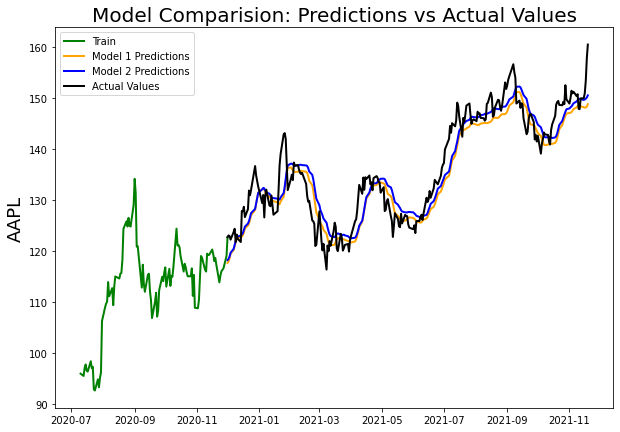

In [ ]:
def getGraphData(data_filtered, train_data_len, y_pred, date_index):
  # The date from which on the date is displayed
  display_start_date = pd.Timestamp('today') - timedelta(days=500)
  # Add the date column
  data_filtered_sub = data_filtered.copy()
  data_filtered_sub['Date'] = date_index

  # Add the difference between the valid and predicted prices
  train = data_filtered_sub[:train_data_len + 1]
  valid = data_filtered_sub[train_data_len:]
  
  valid.insert(1, "Prediction", y_pred.ravel(), True)
  valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
  # Zoom in to a closer timeframe
  valid = valid[valid['Date'] > display_start_date]
  train = train[train['Date'] > display_start_date]
  
  return train, valid

train1, valid1 = getGraphData(data_filtered1, train_data_len1, y_pred1, date_index1)
train2, valid2 = getGraphData(data_filtered2, train_data_len2, y_pred2, date_index2)

# Visualize the data
fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
xt1 = train1['Date']; yt1 = train1[["Close"]]
xv1 = valid1['Date']; yv1 = valid1[["Close", "Prediction"]]
xt2 = train2['Date']; yt2 = train2[["Close"]]
xv2 = valid2['Date']; yv2 = valid2[["Close", "Prediction"]]

plt.title("Model Comparision: Predictions vs Actual Values", fontsize=20)
plt.ylabel(stockname, fontsize=18)
plt.plot(xt1, yt1, color="green", linewidth=2.0)
plt.plot(xv1, yv1["Prediction"], color="orange", linewidth=2.0)
plt.plot(xv2, yv2["Prediction"], color="blue", linewidth=2.0)
plt.plot(xv1, yv1["Close"], color="black", linewidth=2.0)

plt.legend(["Train", "Model 1 Predictions","Model 2 Predictions", "Actual Values"], loc="upper left")
plt.show()